# Project PCD 2025 Kelompok 15 
## Klasifikasi Kematangan Buah Pisang: Mentah, Matang, dan Terlalu Matang/Busuk
Juan Jordan Anugrah (F1D02310061)

Arya Rayan Utama (F1D02310106)

Pinka Dima Calista (F1D02310087)

Rengganis Cahya Andini (F1D02310135)

# Percobaan 1

proses yang digunakan:
1. mengambil V channel dari gambar
2. melakukan ekualisasi histogram

# Import Library

In [5]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder

Mengimpor library yang digunakan seperti OS yang digunakan untuk membaca file dan path direktori, cv2 dari OpenCV digunakan untuk membaca gambar dan mengubahnya menjadi grayscale, matplotlib.pyplot atau plt digunakan untuk menampilkan gambar atau grafik, numpy atau np digunakan untuk operasi perhitungan numerik seperti array, pandas atau pd digunakan untuk membuat dan mengelola data dalam bentuk tabel, train_test_split digunakan untuk membagi dataset menjadi data latih dan data uji, cross_val_predict digunakan untuk melakukan validasi silang agar akurasi model lebih stabil, graycomatrix dan graycoprops digunakan untuk ekstraksi fitur tekstur dari gambar menggunakan metode GLCM, entropy digunakan untuk menghitung nilai entropi atau ketidakteraturan dari data citra, model klasifikasi seperti RandomForestClassifier, SVC, dan KNeighborsClassifier digunakan untuk melakukan proses klasifikasi, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, dan classification_report digunakan untuk mengevaluasi hasil klasifikasi dengan metrik akurasi, presisi, recall, f1-score dan confusion matrix, ConfusionMatrixDisplay digunakan untuk menampilkan confusion matrix dalam bentuk visual, seaborn atau sns digunakan untuk membuat heatmap atau visualisasi korelasi antar variabel, LinearDiscriminantAnalysis atau LDA digunakan untuk reduksi dimensi sekaligus mempertahankan perbedaan antar kelas, dan LabelEncoder digunakan untuk mengubah label dari bentuk teks ke angka agar bisa dibaca oleh model klasifikasi.

## Data Loading

In [6]:
data = []
file_name = []
datalabel = []
path = []
data_distribution = {}

for label in os.listdir("dataset"):
    label_path = os.path.join("dataset", label)
    if not os.path.isdir(label_path):
        continue
    images = os.listdir(label_path)
    data_distribution[label] = len(images)
    print(f"Memproses label: {label}, jumlah gambar: {len(images)}")

    for filename in images:
        img_path = os.path.join(label_path, filename)
        img = cv.imread(img_path)
        if img is not None:
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (350, 350))
            data.append(img)
            datalabel.append(label)  
            file_name.append(filename)
            path.append(img_path)

print("Data: ", len(data))
print("Label: ", len(datalabel))
print("Filenames: ", len(file_name))
print("Data Distribution: ", data_distribution)


Memproses label: ripe, jumlah gambar: 110
Memproses label: rotten, jumlah gambar: 110
Memproses label: unripe, jumlah gambar: 110
Data:  330
Label:  330
Filenames:  330
Data Distribution:  {'ripe': 110, 'rotten': 110, 'unripe': 110}


Langkah pertama di sini kami membuat struktur folder dataset, yang kami gunakan untuk membaca dan memproses data gambar yang tersimpan dalam struktur folder dataset yang berisi subfolder sesuai dengan label atau kelasnya; pertama, setiap folder label dibaca dan jumlah gambar dalam folder tersebut dihitung untuk mengetahui distribusi data per kelas, kemudian untuk setiap gambar dalam folder label tersebut, gambar dibaca menggunakan OpenCV (cv.imread), diubah warnanya dari BGR ke RGB, dan diubah ukurannya menjadi 350x350 piksel; gambar yang sudah diproses ini disimpan dalam list data, sementara labelnya disimpan di datalabel, nama file gambar disimpan di file_name, dan path lengkap gambar disimpan di path; setelah semua data terbaca, program mencetak jumlah total data, label, nama file, dan distribusi data per kelas untuk memastikan proses pembacaan dataset berjalan dengan baik.

# Fungsi DisplayImg

Lalu disini kami membuat Fungsi displayImg yang digunakan untuk menampilkan gambar dalam bentuk grid dengan jumlah baris dan kolom sesuai parameter row dan column. Fungsi membuat figure berukuran 15x10 inci lalu menambahkan subplot untuk tiap gambar dari list data. Setelah semua gambar ditampilkan, fungsi menampilkan grid gambar dengan plt.show(). DisplayImg(12,12, data) akan menampilkan 144 gambar dalam 12 baris dan 12 kolom.

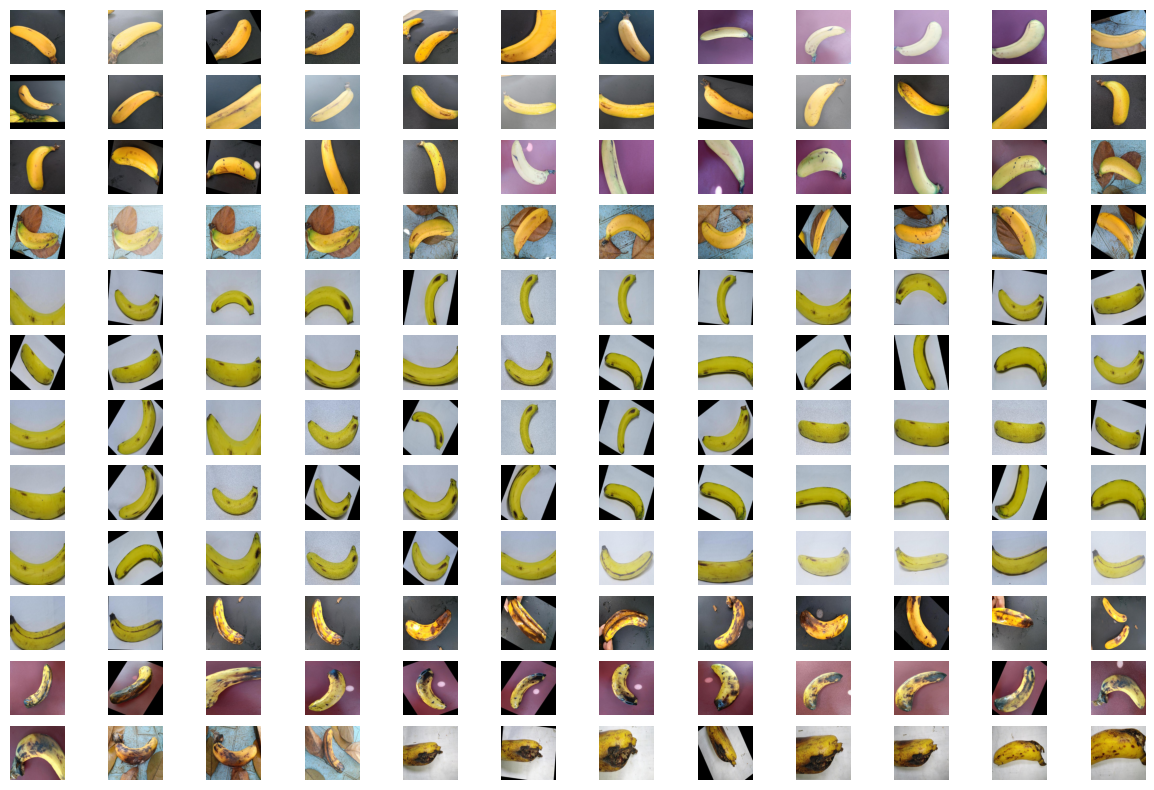

In [7]:
def displayImg(row, column, data):
    fig = plt.figure(figsize=(15, 10))
    for i in range(1, row * column + 1):
        fig.add_subplot(row, column, i)
        plt.imshow(data[i - 1])
        plt.axis('off')  
    plt.show()
displayImg(12,12, data)

## Data Augmentation

### Define Augmentation Function


Selanjutnya disini, kami membuat proses data augmentation, yaitu proses memperbanyak data pelatihan dengan cara memodifikasi gambar asli agar model lebih kuat terhadap variasi. Dua fungsi augmentasi didefinisikan, yaitu fungsi flip_horizontal untuk membalik gambar secara horizontal, dan fungsi rotate untuk memutar gambar 90 derajat searah jarum jam. Dalam perulangan, setiap gambar asli dari list data diambil lalu dibuat dua versi augmentasinya (dibalik dan diputar), kemudian disimpan ke list data_augmented bersama label dan nama file baru yang diberi akhiran _flip dan _rot. Setelah proses selesai, jumlah data sebelum dan sesudah augmentasi dicetak untuk menunjukkan bahwa setiap gambar asli menghasilkan dua gambar tambahan.

In [8]:
data_augmented = [] 
labels_augmented = []
file_name_augmented = []

def flip_horizontal(image):
    tinggi, lebar = image.shape[:2]
    hasil = np.zeros_like(image)
    for y in range(tinggi):
        for x in range(lebar):
            hasil[y][x] = image[y][lebar - 1 - x]
    return hasil


def rotate(image):
    height, width = image.shape[:2]
    hasil = np.zeros((width, height, image.shape[2]), dtype=image.dtype)
    for i in range(height):
        for j in range(width):
            hasil[j][height - 1 - i] = image[i][j]
    return hasil

for i in range(len(data)):
    original = data[i]
    flipped = flip_horizontal(original)
    rotated = rotate(original)

    data_augmented.extend([flipped, rotated])
    labels_augmented.extend([datalabel[i]] * 2)
    file_name_augmented.extend([file_name[i] + '_flip', file_name[i] + '_rot'])

print("Jumlah data sebelum augmentasi:", len(data))
print("Jumlah data setelah augmentasi:", len(data_augmented))


Jumlah data sebelum augmentasi: 330
Jumlah data setelah augmentasi: 660


## Data Preparation

### Define Preprocessing Function


In [9]:
def rgb_to_v_channel(img_rgb):
    img_rgb = img_rgb.astype('float32') / 255.0
    height, width, _ = img_rgb.shape
    V_channel = np.zeros((height, width), dtype='float32')

    for y in range(height):
        for x in range(width):
            r, g, b = img_rgb[y, x]
            mx = max(r, g, b)
            V_channel[y, x] = mx

    return (V_channel * 255).astype(np.uint8)

def histogram_equalization(v_channel):
    hist = np.zeros(256, dtype=int)
    for y in range(v_channel.shape[0]):
        for x in range(v_channel.shape[1]):
            hist[v_channel[y, x]] += 1

    cdf = np.cumsum(hist)
    cdf_min = cdf[np.nonzero(cdf)].min()
    total_pixels = v_channel.size

    equalized = np.zeros_like(v_channel)
    for i in range(256):
        new_value = round((cdf[i] - cdf_min) / (total_pixels - cdf_min) * 255)
        equalized[v_channel == i] = new_value

    return equalized.astype(np.uint8)

Selanjutnya disini, kami membuat proses preparation untuk tahap preprocessing sebelum gambar digunakan dalam proses klasifikasi. Pertama, terdapat fungsi rgb_to_v_channel yang digunakan untuk mengambil channel V (Value) dari gambar RGB. Channel ini mewakili tingkat kecerahan dari suatu piksel dan dihitung dengan mengambil nilai maksimum dari komponen R, G, dan B pada setiap piksel. Setelah nilai V diperoleh, nilainya dikembalikan dalam rentang 0–255 agar sesuai dengan format grayscale. Kemudian, fungsi histogram_equalization digunakan untuk memperbaiki kontras gambar dengan cara melakukan ekualisasi histogram. Proses ini dimulai dengan menghitung histogram dari gambar grayscale, kemudian menghitung nilai kumulatifnya atau cumulative distribution function (CDF). Nilai CDF ini digunakan untuk meredistribusi intensitas piksel, sehingga gambar yang tadinya terlalu terang atau terlalu gelap menjadi lebih seimbang pencahayaannya.

### Menampilkan Visualisasi sampel
Di sini, kami mengambil masing-masing 10 gambar dari tiga kelas: ripe, unripe, dan rotten, untuk divisualisasikan setelah melalui proses preprocessing. Setiap gambar dicek labelnya, lalu jika jumlah gambar untuk kelas tersebut belum mencapai 10, gambar akan diproses menggunakan fungsi rgb_to_v_channel untuk mengambil nilai kecerahan (V), kemudian dilakukan perbaikan kontras dengan histogram_equalization. Gambar yang telah diproses disimpan ke dalam list sesuai kelasnya. Setelah ketiga kelas masing-masing memiliki 10 gambar, proses dihentikan dan gambar ditampilkan dalam grid 2x5 menggunakan displayImg untuk melihat hasil visual dari preprocessing tersebut.

Ripe Samples


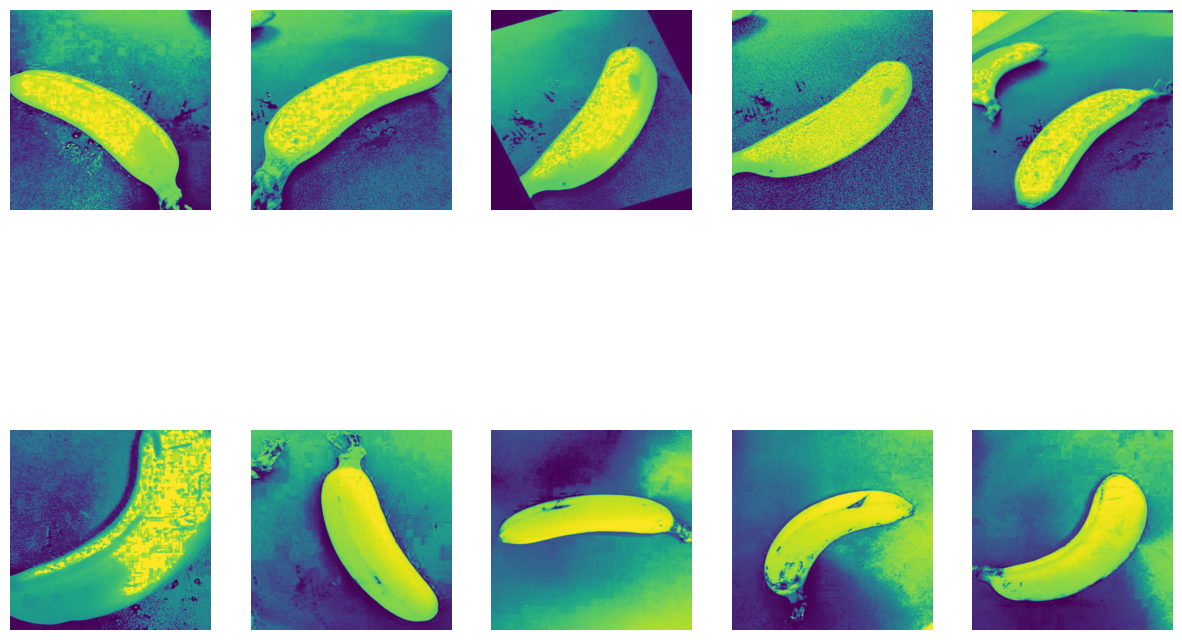

Unripe Samples


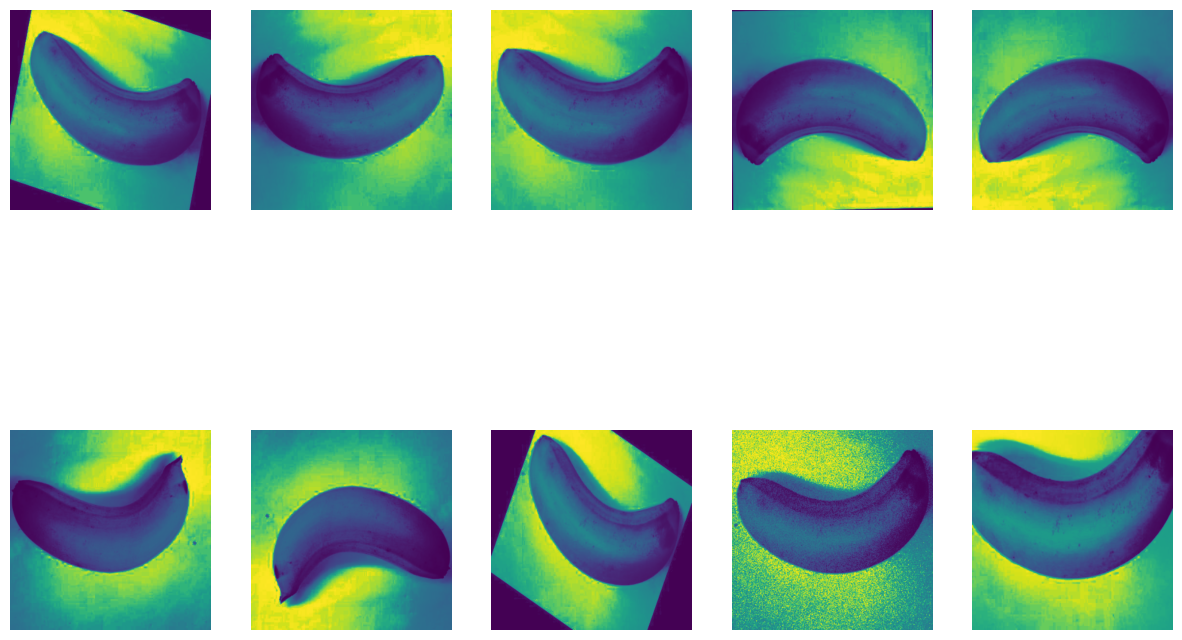

Rotten Samples


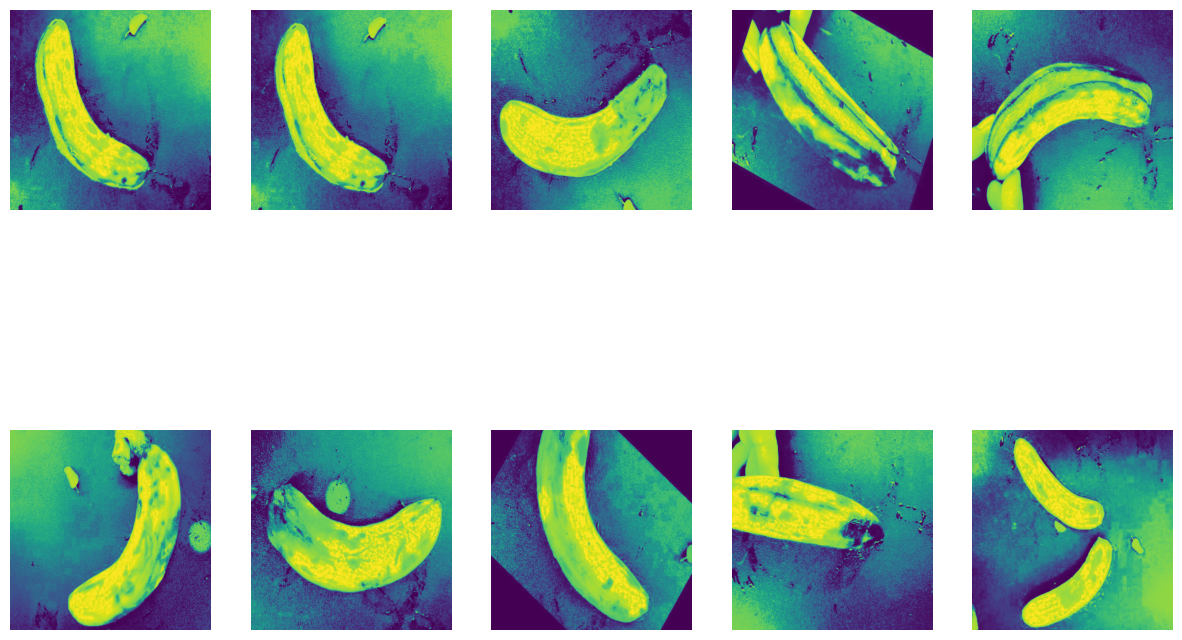

In [10]:
ripe = []
unripe = []
rotten = []


for i in range(len(data)):
    if datalabel[i].lower() == 'ripe' and len(ripe) < 10:
        proc = rgb_to_v_channel(data[i])
        proc = histogram_equalization(proc)
        ripe.append(proc)
        
    elif datalabel[i].lower() == 'unripe' and len(unripe) < 10:
        proc = rgb_to_v_channel(data[i])
        proc = histogram_equalization(proc)
        unripe.append(proc)

    elif datalabel[i].lower() == 'rotten' and len(rotten) < 10:
        proc = rgb_to_v_channel(data[i])
        proc = histogram_equalization(proc)
        rotten.append(proc)

    if len(ripe) >= 10 and len(unripe) >= 10 and len(rotten) >= 10:
        break

print("Ripe Samples")
displayImg(2, 5, ripe)

print("Unripe Samples")
displayImg(2, 5, unripe)

print("Rotten Samples")
displayImg(2, 5, rotten)



### Preprocessing

In [11]:
dataPreprocessed = []
for i in range(len(data_augmented)):
    proc = rgb_to_v_channel(data_augmented[i])
    proc = histogram_equalization(proc)

    dataPreprocessed.append(proc.astype(np.uint8))

Selanjutnya di bagian ini, kami melakukan preprocessing terhadap seluruh gambar yang telah melalui proses augmentasi. Setiap gambar pada list data_augmented diproses satu per satu dengan terlebih dahulu dikonversi ke channel Value (V) menggunakan fungsi rgb_to_v_channel, yang mengambil tingkat kecerahan dari masing-masing piksel. Setelah itu, gambar dilanjutkan dengan proses histogram_equalization untuk meningkatkan kontras agar informasi visual lebih jelas dan merata. Hasil gambar yang telah diproses kemudian dikonversi ke format 8-bit (uint8) dan disimpan ke dalam list dataPreprocessed. Dengan demikian, semua gambar hasil augmentasi kini siap digunakan untuk tahap ekstraksi fitur atau pelatihan model klasifikasi.

### Feature Extraction

In [12]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Selajutnya, kami mulai masuk ke tahap ekstraksi fitur menggunakan metode GLCM (Gray-Level Co-occurrence Matrix). Fungsi glcm dibuat untuk menghasilkan matriks GLCM dari sebuah gambar grayscale berdasarkan arah sudut tertentu. Parameter derajat digunakan untuk menentukan arah pasangan piksel yang dianalisis, yaitu 0°, 45°, 90°, atau 135°. Setiap sudut tersebut dikonversi ke dalam bentuk radian karena fungsi graycomatrix dari skimage memerlukan input sudut dalam satuan radian. Setelah sudut ditentukan, fungsi graycomatrix dipanggil untuk menghitung GLCM dari gambar dengan jarak antar piksel sebesar 1. GLCM ini akan merepresentasikan seberapa sering pasangan nilai intensitas piksel tertentu muncul dalam arah yang ditentukan, dan hasilnya akan digunakan untuk menghitung fitur tekstur seperti contrast, correlation, energy, dan homogeneity di tahap selanjutnya.

# Membuat Fungsi - Fungsi untuk melakukan Proses Perhitungan

In [13]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Fungsi di atas merupakan Fungsi correlation yang digunakan untuk menghitung fitur tekstur korelasi dari matriks GLCM. Fungsi menerima matriks GLCM sebagai input dan mengembalikan nilai korelasi menggunakan graycoprops. 

In [14]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Fungsi di atas merupakan fungsi dissimilarity yang digunakan untuk menghitung fitur tekstur dissimilarity dari matriks GLCM. Fungsi menerima matriks GLCM sebagai input dan mengembalikan nilai dissimilarity menggunakan graycoprops.

In [15]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Fungsi di atas merupakan fungsi homogenity yang digunakan untuk menghitung fitur tekstur homogeneity dari matriks GLCM. Fungsi menerima matriks GLCM sebagai input dan mengembalikan nilai homogeneity menggunakan graycoprops. Nilai ini mengukur seberapa dekat distribusi elemen dalam GLCM terhadap diagonal utama, yang mencerminkan tingkat keseragaman tekstur pada citra.

In [16]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Fungsi di atas merupakan fungsi contrast yang digunakan untuk menghitung fitur tekstur contrast dari matriks GLCM. Fungsi ini menerima matriks GLCM sebagai input dan mengembalikan nilai contrast menggunakan graycoprops.

In [17]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Fungsi di atas merupakan fungsi ASM (Angular Second Moment) yang digunakan untuk menghitung fitur tekstur dari matriks GLCM. Fungsi ini menerima matriks GLCM sebagai input dan mengembalikan nilai ASM menggunakan graycoprops. Nilai ASM menunjukkan tingkat keseragaman tekstur dalam gambar - semakin tinggi nilainya, semakin seragam tekstur gambar tersebut.

In [18]:
def energy(matrix):
    return graycoprops(matrix, 'energy')[0, 0]

Fungsi di atas merupakan fungsi energy yang digunakan untuk menghitung fitur tekstur energy dari matriks GLCM. Fungsi ini menerima matriks GLCM sebagai input dan mengembalikan nilai energy menggunakan graycoprops.

In [19]:
def entropyGlcm(matrix):
    glcm_array = matrix[:, :, 0, 0]
    return entropy(glcm_array.flatten())

Fungsi di atas merupakan fungsi entropyGlcm yang digunakan untuk menghitung nilai entropi dari matriks GLCM. Fungsi ini mengambil GLCM sebagai input, kemudian mengekstrak matriks 2D dari dimensi [0, 0] (karena hasil graycomatrix berbentuk 4 dimensi), lalu meratakannya menjadi array 1 dimensi. Nilai entropi dihitung menggunakan fungsi entropy dari scipy.stats, yang mengukur tingkat ketidakteraturan atau kompleksitas dalam distribusi nilai GLCM

In [20]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Cell di atas digunakan untuk menghitung matriks GLCM pada empat sudut arah yang berbeda, yaitu 0°, 45°, 90°, dan 135°, untuk setiap gambar hasil preprocessing. Dalam perulangan, setiap gambar pada dataPreprocessed diproses dengan memanggil fungsi glcm sebanyak empat kali masing-masing untuk satu arah sudut. Hasil dari setiap sudut disimpan ke dalam list yang berbeda: Derajat0, Derajat45, Derajat90, dan Derajat135.

In [21]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

Cell di atas merupakan inisialisasi list kosong untuk menyimpan nilai-nilai fitur tekstur yang akan diekstraksi dari matriks GLCM pada empat arah sudut: 0°, 45°, 90°, dan 135°. Setiap fitur seperti Kontras, Dissimilarity, Homogenity, Entropy, ASM, Energy, dan Correlation dikelompokkan berdasarkan arah sudutnya. Nantinya, setiap list ini akan diisi dengan nilai-nilai hasil ekstraksi fitur dari GLCM gambar.

In [22]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Cell di atas digunakan untuk menghitung nilai korelasi (correlation) dari matriks GLCM untuk setiap gambar hasil preprocessing pada empat arah sudut, yaitu 0°, 45°, 90°, dan 135°. Dalam setiap iterasi, matriks GLCM yang sesuai dengan sudut tertentu diambil dari list Derajat0, Derajat45, Derajat90, dan Derajat135, lalu dihitung nilainya menggunakan fungsi correlation. Hasilnya kemudian disimpan ke dalam list correlation0, correlation45, correlation90, dan correlation135.

In [23]:
for i in range(len(data_augmented)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Cell di atas digunakan untuk menghitung nilai kontras (contrast) dari matriks GLCM setiap gambar hasil augmentasi pada empat arah sudut: 0°, 45°, 90°, dan 135°. Dalam perulangan, fungsi contrast dipanggil untuk masing-masing sudut, lalu hasilnya disimpan ke dalam list Kontras0, Kontras45, Kontras90, dan Kontras135. Nilai kontras ini menggambarkan seberapa besar perbedaan intensitas antar piksel dalam tekstur gambar semakin tinggi nilainya, semakin tajam perbedaan antar piksel

In [24]:
for i in range(len(data_augmented)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Cell di atas digunakan untuk menghitung nilai dissimilarity dari matriks GLCM pada setiap gambar hasil augmentasi untuk empat arah sudut: 0°, 45°, 90°, dan 135°. Dalam setiap iterasi, fungsi dissimilarity dipanggil untuk masing-masing sudut dan hasilnya disimpan ke dalam list dissimilarity0, dissimilarity45, dissimilarity90, dan dissimilarity135. Nilai dissimilarity ini mengukur seberapa besar perbedaan intensitas antar pasangan piksel yang berdekatan semakin tinggi nilainya, semakin kasar atau kontras teksturnya.

In [25]:
for i in range(len(data_augmented)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Cell di atas digunakan untuk menghitung nilai homogenitas (homogeneity) dari matriks GLCM untuk setiap gambar hasil augmentasi pada empat arah sudut: 0°, 45°, 90°, dan 135°. Dalam setiap iterasi, fungsi homogenity digunakan untuk menghitung seberapa seragam atau halus suatu tekstur dalam gambar. Hasilnya kemudian disimpan ke dalam list homogenity0, homogenity45, homogenity90, dan homogenity135. Nilai homogenitas yang tinggi menunjukkan bahwa nilai piksel dalam gambar cenderung serupa satu sama lain, yang berarti teksturnya lebih halus.

In [26]:
for i in range(len(data_augmented)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Cell di atas digunakan untuk menghitung nilai entropi (entropy) dari matriks GLCM untuk setiap gambar hasil augmentasi pada empat arah sudut: 0°, 45°, 90°, dan 135°. Fungsi entropyGlcm digunakan untuk mengukur tingkat ketidakpastian atau kompleksitas tekstur dalam gambar berdasarkan distribusi nilai pada GLCM. Setiap hasil dihitung per sudut dan disimpan ke dalam list entropy0, entropy45, entropy90, dan entropy135. 

In [27]:
for i in range(len(data_augmented)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Cell di atas digunakan untuk menghitung nilai ASM (Angular Second Moment) atau sering disebut uniformity dari matriks GLCM untuk gambar hasil augmentasi pada empat sudut berbeda: 0°, 45°, 90°, dan 135°. ASM mengukur keseragaman tekstur—semakin tinggi nilainya, semakin seragam teksturnya. Nilai ini dihitung menggunakan fungsi ASM untuk setiap arah dan hasilnya disimpan dalam list ASM0, ASM45, ASM90, dan ASM135. 

In [28]:
for i in range(len(data_augmented)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Cell di atas digunakan untuk menghitung nilai Energy dari matriks GLCM pada gambar hasil augmentasi untuk empat sudut berbeda: 0°, 45°, 90°, dan 135°. Energy merupakan ukuran tekstur yang menunjukkan homogenitas dan kekuatan pola berulang dalam gambar; nilainya lebih tinggi jika distribusi piksel lebih konsisten. Perhitungan dilakukan menggunakan fungsi energy untuk masing-masing arah, dan hasilnya disimpan ke dalam list energy0, energy45, energy90, dan energy135.

### Write the extraction's results to CSV 

Cell di bawah digunakan untuk menyimpan hasil ekstraksi fitur tekstur ke dalam file CSV agar data tersebut dapat disimpan dan digunakan kembali dengan mudah. Pertama, semua fitur seperti kontras, homogenitas, dissimilarity, entropi, ASM, energi, dan korelasi untuk keempat sudut (0°, 45°, 90°, 135°), beserta nama file dan labelnya, dikumpulkan ke dalam sebuah dictionary bernama dataTable. Dictionary ini kemudian dikonversi menjadi DataFrame menggunakan pandas.DataFrame. Setelah itu, DataFrame tersebut disimpan ke file CSV bernama 'hasil_ekstraksi_1.csv' tanpa menyertakan indeks baris (index=False). Terakhir, file CSV tersebut dibaca kembali ke dalam variabel hasilEkstrak.

In [29]:
dataTable = {'Filename': file_name_augmented, 'Label': labels_augmented,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,musa-acuminata-banana-ad772802-394a-11ec-996c-...,ripe,183.423537,387.781874,233.234761,286.258709,0.487513,0.361111,0.436947,0.374951,...,0.005486,0.004527,0.079500,0.066514,0.074068,0.067282,0.982962,0.963976,0.978349,0.973407
1,musa-acuminata-banana-ad772802-394a-11ec-996c-...,ripe,233.234761,387.781874,183.423537,286.258709,0.436947,0.361111,0.487513,0.374951,...,0.006320,0.004527,0.074068,0.066514,0.079500,0.067282,0.978349,0.963976,0.982962,0.973407
2,musa-acuminata-banana-adb78123-394a-11ec-93c6-...,ripe,154.564928,256.596966,218.609955,347.432361,0.441892,0.340537,0.367769,0.310744,...,0.004353,0.003695,0.073303,0.062827,0.065978,0.060785,0.985954,0.976692,0.980114,0.968441
3,musa-acuminata-banana-adb78123-394a-11ec-93c6-...,ripe,218.609955,256.596966,154.564928,347.432361,0.367769,0.340537,0.441892,0.310744,...,0.005373,0.003695,0.065978,0.062827,0.073303,0.060785,0.980114,0.976692,0.985954,0.968441
4,musa-acuminata-banana-addcca4d-394a-11ec-b76c-...,ripe,108.633926,176.588263,135.946451,232.067397,0.479021,0.408936,0.458803,0.389173,...,0.013493,0.012622,0.116672,0.112504,0.116159,0.112349,0.991587,0.986306,0.989466,0.982004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,musa-acuminata-unripe-7fecfc48-1d0a-11ec-b38a-...,unripe,78.158223,129.638197,82.730888,145.669264,0.458480,0.341547,0.414663,0.331320,...,0.004095,0.003164,0.070970,0.057313,0.063990,0.056246,0.993068,0.988521,0.992672,0.987101
656,musa-acuminata-unripe-86526c32-1d0a-11ec-9731-...,unripe,72.696251,115.563772,64.588481,124.320933,0.396613,0.321578,0.449627,0.316043,...,0.003042,0.001845,0.048434,0.043771,0.055150,0.042957,0.993466,0.989628,0.994199,0.988842
657,musa-acuminata-unripe-86526c32-1d0a-11ec-9731-...,unripe,64.588481,115.563772,72.696251,124.320933,0.449627,0.321578,0.396613,0.316043,...,0.002346,0.001845,0.055150,0.043771,0.048434,0.042957,0.994199,0.989628,0.993466,0.988842
658,musa-acuminata-unripe-87eec399-1d0a-11ec-8732-...,unripe,68.590111,114.322863,56.443062,102.082035,0.568607,0.470636,0.619105,0.477453,...,0.013511,0.009041,0.105242,0.094072,0.116237,0.095084,0.994052,0.990103,0.995109,0.991162


### Features Selection

In [30]:
X = hasilEkstrak.drop(columns=['Label', 'Filename'])
y = hasilEkstrak['Label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

lda = LDA(n_components=2)
X_lda = lda.fit_transform(X, y_encoded)

df_lda = pd.DataFrame(X_lda, columns=[f'LD{i+1}' for i in range(X_lda.shape[1])])
df_lda['Label'] = y
df_lda['Filename'] = hasilEkstrak['Filename']

x_new = df_lda.drop(columns=['Label', 'Filename'])
y_new = df_lda['Label']
x_new.corr()

,LD1,LD2
LD1,1.000000e+00,-1.657127e-14
LD2,-1.657127e-14,1.000000e+00


Cell di atas menunjukkan seleksi fitur menggunakan Linear Discriminant Analysis (LDA) untuk mereduksi fitur menjadi dua komponen utama yang paling relevan dengan label kelas. Pertama, fitur (X) dan label (y) dipersiapkan, lalu label di-encode ke angka. LDA kemudian diterapkan menghasilkan dua fitur baru (LD1 dan LD2). Hasil ini disimpan ke DataFrame bersama label dan nama file. Terakhir, korelasi antar fitur baru dihitung untuk melihat hubungan antar fitur.

## Splitting Data

Cell di bawah digunakan untuk membagi dataset hasil seleksi fitur menjadi data pelatihan dan data pengujian menggunakan fungsi train_test_split. Parameter test_size=0.2 berarti 20% data akan dipakai sebagai data uji, sedangkan 80% sisanya untuk pelatihan. random_state=42 digunakan agar pembagian data konsisten dan bisa direproduksi. Setelah pemisahan, ukuran dari data pelatihan (X_train) dan data pengujian (X_test) dicetak untuk memastikan pembagian sudah sesuai.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(528, 2)
(132, 2)


## Feature Normalization

In [32]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Proses di atas merupakan normalisasi data menggunakan metode Standardization atau Z-score, yang bertujuan untuk menyamakan skala setiap fitur agar memiliki rata-rata (mean) 0 dan standar deviasi 1. Langkah ini penting karena banyak algoritma pembelajaran mesin bekerja lebih baik jika data berada dalam skala yang seragam. Pada kode tersebut, X_train dinormalisasi menggunakan rata-rata dan standar deviasi dari dirinya sendiri, sedangkan X_test dinormalisasi menggunakan rata-rata dan standar deviasi dari X_train agar konsisten dengan data pelatihan.

## Modeling

### Define Model

Pada bagian ini, kami mendefinisikan model klasifikasi yang akan digunakan untuk mengenali kelas dari data citra berdasarkan fitur yang telah diekstraksi dan dinormalisasi. Fungsi generateClassificationReport dibuat untuk menampilkan metrik evaluasi model seperti classification report, confusion matrix, dan nilai akurasi. Tiga jenis model dipersiapkan: RandomForestClassifier dengan 5 pohon keputusan (n_estimators=5), SVC (Support Vector Machine) dengan kernel radial basis function (rbf), dan KNeighborsClassifier dengan 5 tetangga terdekat.

In [33]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

Pada bagian ini, model klasifikasi Random Forest dilatih menggunakan data pelatihan (X_train dan y_train). Setelah model dilatih, dilakukan prediksi pada data pelatihan untuk melihat seberapa baik model mempelajari data yang diberikan. Evaluasi dilakukan menggunakan fungsi generateClassificationReport yang menampilkan metrik performa seperti akurasi, confusion matrix, dan classification report. Kemudian, model juga diuji pada data pengujian (X_test) untuk mengetahui kemampuan generalisasi model terhadap data baru yang belum pernah dilihat.

In [ ]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

        ripe       0.99      0.99      0.99       171
      rotten       0.99      1.00      1.00       178
      unripe       1.00      0.99      0.99       179

    accuracy                           0.99       528
   macro avg       0.99      0.99      0.99       528
weighted avg       0.99      0.99      0.99       528

[[170   1   0]
 [  0 178   0]
 [  2   0 177]]
Accuracy: 0.9943181818181818

------Testing Set------
              precision    recall  f1-score   support

        ripe       0.96      0.90      0.93        49
      rotten       0.88      0.90      0.89        42
      unripe       0.91      0.95      0.93        41

    accuracy                           0.92       132
   macro avg       0.92      0.92      0.92       132
weighted avg       0.92      0.92      0.92       132

[[44  5  0]
 [ 0 38  4]
 [ 2  0 39]]
Accuracy: 0.9166666666666666


### Train SVM Classifier

Pada bagian ini, model Support Vector Machine (SVM) dilatih menggunakan data pelatihan (X_train dan y_train). Setelah pelatihan selesai, model digunakan untuk melakukan prediksi pada data pelatihan terlebih dahulu. Hasil prediksi tersebut dievaluasi menggunakan fungsi generateClassificationReport, yang menampilkan metrik seperti akurasi, confusion matrix, dan classification report. Selanjutnya, model juga diuji pada data pengujian (X_test) untuk mengevaluasi performanya terhadap data yang belum pernah dilihat sebelumnya.

In [ ]:
# Train SVM Classifier
svm.fit(X_train, y_train)

print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

        ripe       0.82      0.71      0.76       171
      rotten       0.71      0.91      0.80       178
      unripe       0.85      0.72      0.78       179

    accuracy                           0.78       528
   macro avg       0.79      0.78      0.78       528
weighted avg       0.79      0.78      0.78       528

[[121  34  16]
 [  9 162   7]
 [ 18  33 128]]
Accuracy: 0.7784090909090909

------Testing Set------
              precision    recall  f1-score   support

        ripe       0.83      0.71      0.77        49
      rotten       0.64      0.90      0.75        42
      unripe       0.90      0.68      0.78        41

    accuracy                           0.77       132
   macro avg       0.79      0.77      0.77       132
weighted avg       0.79      0.77      0.77       132

[[35 14  0]
 [ 1 38  3]
 [ 6  7 28]]
Accuracy: 0.7651515151515151


### Train KNN Classifier

Di bagian ini, model K-Nearest Neighbors (KNN) dilatih menggunakan data pelatihan (X_train dan y_train). Setelah proses pelatihan selesai, model digunakan untuk memprediksi label pada data pelatihan untuk melihat performa awalnya. Hasil prediksi dievaluasi dengan menampilkan metrik seperti akurasi, confusion matrix, dan classification report melalui fungsi generateClassificationReport. Selanjutnya, model diuji pada data pengujian (X_test) untuk menilai kemampuan KNN dalam mengklasifikasikan data baru yang belum pernah dilihat sebelumnya. 

In [ ]:
# Train KNN Classifier
knn.fit(X_train, y_train)

print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

        ripe       0.83      0.81      0.82       171
      rotten       0.77      0.90      0.83       178
      unripe       0.88      0.76      0.82       179

    accuracy                           0.82       528
   macro avg       0.83      0.82      0.82       528
weighted avg       0.83      0.82      0.82       528

[[138  21  12]
 [ 12 160   6]
 [ 17  26 136]]
Accuracy: 0.821969696969697

------Testing Set------
              precision    recall  f1-score   support

        ripe       0.79      0.69      0.74        49
      rotten       0.62      0.81      0.70        42
      unripe       0.88      0.73      0.80        41

    accuracy                           0.74       132
   macro avg       0.76      0.75      0.75       132
weighted avg       0.76      0.74      0.75       132

[[34 13  2]
 [ 6 34  2]
 [ 3  8 30]]
Accuracy: 0.7424242424242424


## Evaluation With Confusion Matrix

Kode di bawah digunakan untuk memvisualisasikan hasil evaluasi model klasifikasi dengan confusion matrix. Fungsi plot_confusion_matrix menerima data asli (y_true) dan hasil prediksi (y_pred), lalu menghitung confusion matrix menggunakan confusion_matrix dari scikit-learn. Matriks tersebut kemudian ditampilkan dalam bentuk grafik menggunakan ConfusionMatrixDisplay dengan warna biru agar mudah dibaca. Setelah fungsi didefinisikan, confusion matrix untuk tiga model yang sudah dilatih (Random Forest, SVM, dan KNN) divisualisasikan satu per satu dengan judul yang sesuai, sehingga kita dapat membandingkan performa masing-masing model secara visual.

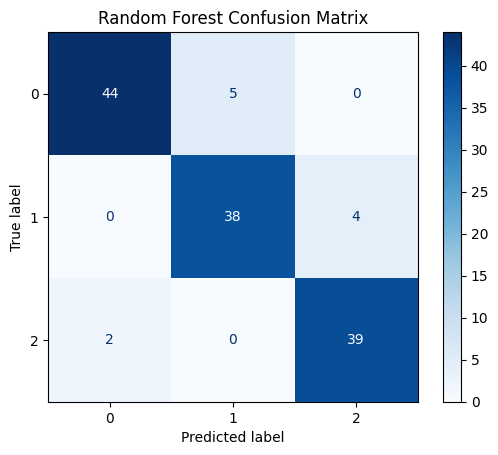

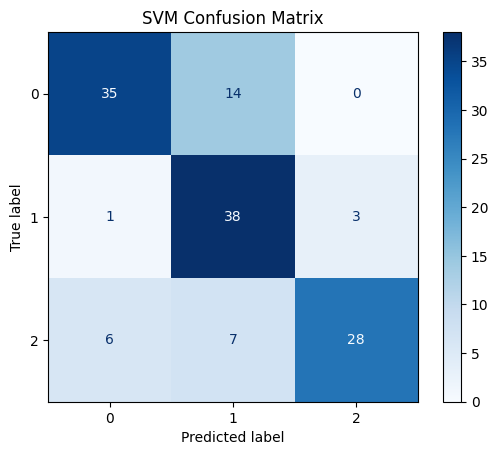

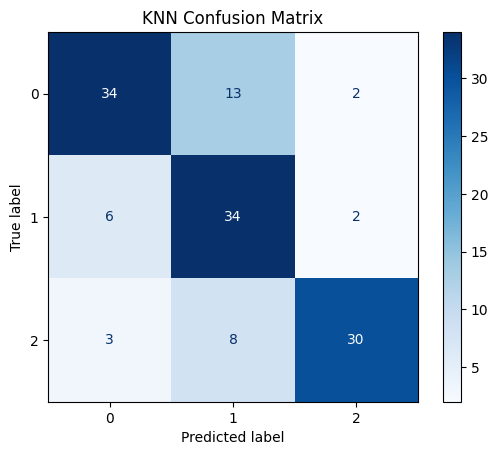

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")